# LSTM

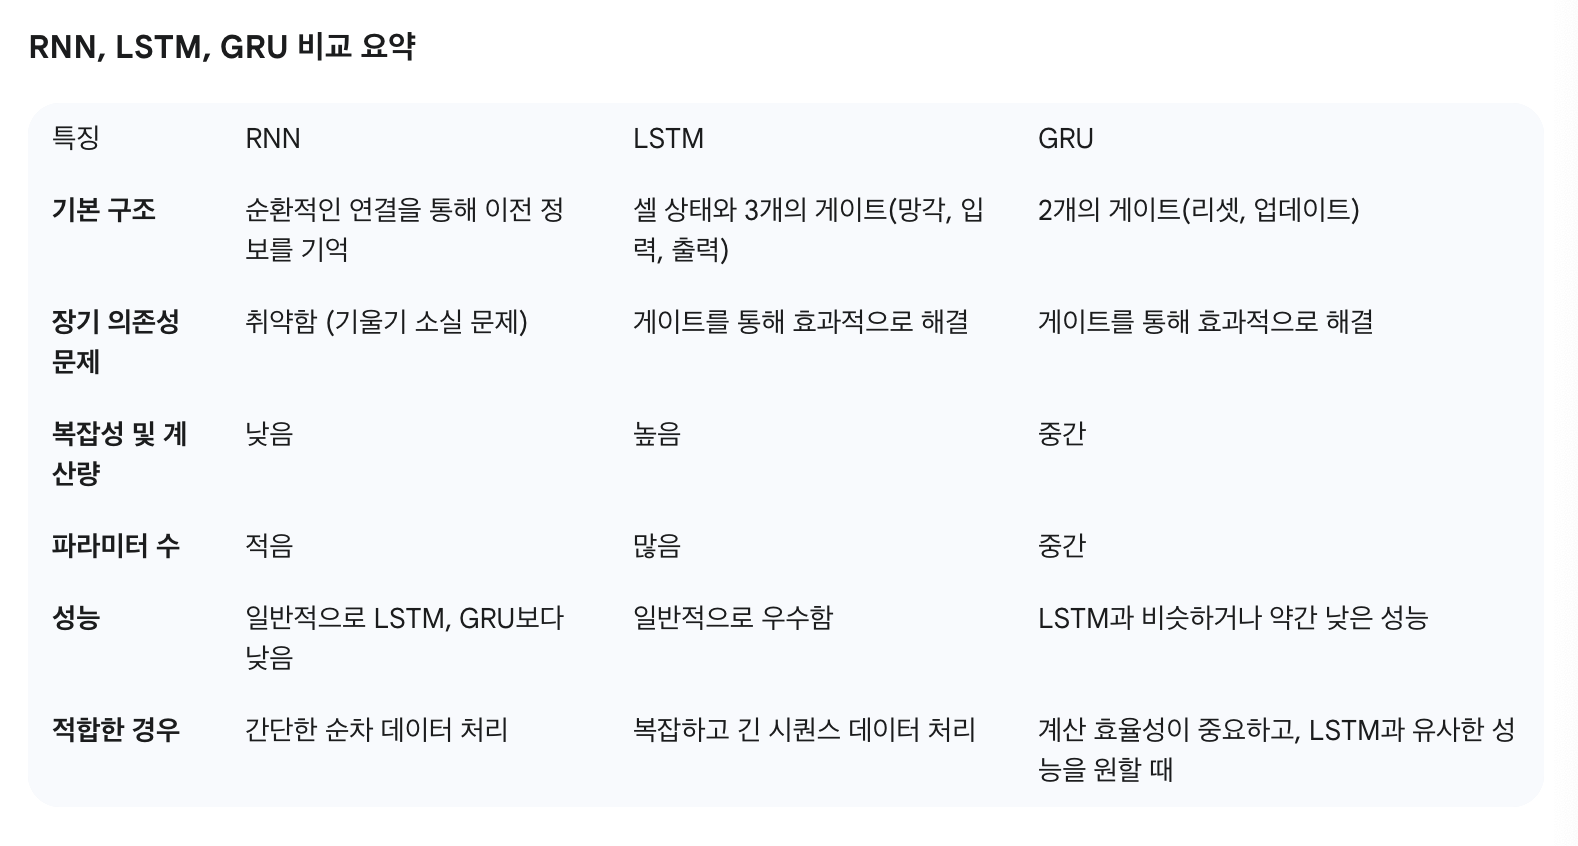

### 데이터 준비

In [3]:
from tensorflow.keras.datasets import imdb
import torch
import torch.nn.functional as F

VOCAB_SIZE = 300    # 사용할 단어 수
SEQ_LEN = 150       # 시퀀스 하나의 최대 길이

# 데이터 로드
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=VOCAB_SIZE)

# Torch Tensor 변환
train_input = [torch.tensor(seq, dtype=torch.long) for seq in train_input][:10000]
test_input = [torch.tensor(seq, dtype=torch.long) for seq in test_input][:5000]

train_target = torch.tensor(train_target, dtype=torch.long)[:10000]
test_target = torch.tensor(test_target, dtype=torch.long)[:5000]

# 패딩 처리
def pad_sequences(sequences, maxlen, padding_value=0):
    padded_sequences = [F.pad(seq[:maxlen], (0, max(0, maxlen-len(seq))), value=padding_value) for seq in sequences]
    return torch.stack(padded_sequences)

train_seq = pad_sequences(train_input, maxlen=SEQ_LEN)
test_seq = pad_sequences(test_input, maxlen=SEQ_LEN)

# 원핫인코딩 처리
train_onehot = F.one_hot(train_seq, num_classes=VOCAB_SIZE).float()
test_onehot = F.one_hot(test_seq, num_classes=VOCAB_SIZE).float()

# label 데이터 실수 처리
train_target = train_target.float()
test_target = test_target.float()

train_onehot.shape, test_onehot.shape

(torch.Size([10000, 150, 300]), torch.Size([5000, 150, 300]))

### 학습 함수 정의

In [4]:
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

def train_func(train_data, train_label, model):
    # 학습을 위한 설정
    # 배치 사이즈, 학습/검증셋 크기 설정
    BATCH_SIZE = 65
    train_size = int(len(train_data) * 0.8)
    val_size = len(train_data) - train_size

    # 데이터 학습/검증셋 분할
    train_dataset, val_dataset = random_split(TensorDataset(train_data, train_label), [train_size, val_size])
    # 미니배치로 사용할 수 있도록 DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # epoch(학습 횟수), 손실 함수, 최적화 함수 정의
    epochs = 100
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)

    # 시각화를 위한 손실값/정확도 저장용 배열 생성 
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    # 조기종료 관련 변수 초기화
    early_stopping_patience = 7
    best_val_loss = float('inf')
    early_stop_counter = 0

    # 학습 진행
    for epoch in range(epochs):

        # 학습 모드
        model.train()
        total_loss, correct, total = 0, 0, 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()               # 가중치 초기화
            outputs = model(inputs).squeeze()   # 순전파

            loss = criterion(outputs, targets)  # 손실 계산

            loss.backward()                     # 역전파
            optimizer.step()                    # 가중치 갱신
            total_loss += loss.item()

            pred = (outputs > 0.5).float()
            correct += (pred == targets).sum().item()
            total += targets.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # 검증 모드
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_outputs = model(val_inputs).squeeze()
                loss = criterion(val_outputs, val_targets)
                val_loss += loss.item()

                val_pred = (val_outputs > 0.5).float()
                val_correct += (val_pred == val_targets).sum().item()
                val_total += val_targets.size(0)

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # 조기 종료
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stopping_patience:
                print("Early Stopping 할게~~~~~!")
                break

    # 학습 과정 시각화
    train_history_df = pd.DataFrame({
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs
    })

    train_history_df.plot()
    plt.show()

### 평가 함수 정의

In [5]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for val_inputs, val_targets in test_loader:
            val_outputs = model(val_inputs).squeeze()
            loss = criterion(val_outputs, val_targets)
            val_loss += loss.item()

            val_pred = (val_outputs > 0.5).float()
            val_correct += (val_pred == val_targets).sum().item()
            val_total += val_targets.size(0)

    val_loss = val_loss / len(test_loader)
    val_acc = val_correct / val_total
    return val_loss, val_acc

### 모델 준비 및 학습

##### LSTM (One-hot Encoding)

In [6]:
import torch
import torch.nn as nn

class SentimentLSTM(nn.Module):
    def __init__(self, seq_len, vocab_size, hidden_dim, output_dim):
        super(SentimentLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=vocab_size, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden)
        return self.sigmoid(out)

In [7]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1

lstm_model = SentimentLSTM(
    seq_len=SEQ_LEN, 
    vocab_size=VOCAB_SIZE,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM
)

print(lstm_model)

SentimentLSTM(
  (lstm): LSTM(300, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoch 1/100 | Train Loss: 0.6934, Train Acc: 0.5020, Val Loss: 0.6926, Val Acc: 0.5000
Epoch 2/100 | Train Loss: 0.6906, Train Acc: 0.5331, Val Loss: 0.6897, Val Acc: 0.5435
Epoch 3/100 | Train Loss: 0.6774, Train Acc: 0.5847, Val Loss: 0.6778, Val Acc: 0.5835
Epoch 4/100 | Train Loss: 0.6864, Train Acc: 0.5639, Val Loss: 0.6929, Val Acc: 0.5160
Epoch 5/100 | Train Loss: 0.6925, Train Acc: 0.5108, Val Loss: 0.6925, Val Acc: 0.5170
Epoch 6/100 | Train Loss: 0.6909, Train Acc: 0.5306, Val Loss: 0.6918, Val Acc: 0.5090
Epoch 7/100 | Train Loss: 0.6887, Train Acc: 0.5493, Val Loss: 0.6913, Val Acc: 0.5295
Epoch 8/100 | Train Loss: 0.6863, Train Acc: 0.5539, Val Loss: 0.6905, Val Acc: 0.5175
Epoch 9/100 | Train Loss: 0.6805, Train Acc: 0.5651, Val Loss: 0.6875, Val Acc: 0.5395
Epoch 10/100 | Train Loss: 0.6693, Train Acc: 0.5895, Val Loss: 0.6900, Val Acc: 0.5480
Early Stopping 할게~~~~~!


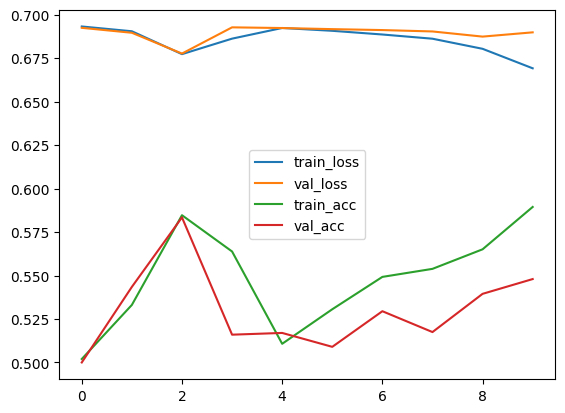

In [8]:
train_func(train_onehot, train_target, lstm_model)

In [9]:
test_dataset = TensorDataset(test_onehot, test_target)
test_loader = DataLoader(test_dataset, batch_size=65)

criterion = nn.BCELoss()

loss, accuracy = evaluate_model(lstm_model, test_loader, criterion)
loss, accuracy

(0.6915311550165152, 0.5366)

##### LSTM (Embedding)

In [ ]:
class EBDSentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(EBDSentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden)
        return self.sigmoid(out)

In [11]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1
EMBEDDING_DIM = 50

ebd_lstm_model = EBDSentimentLSTM(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM
)

print(ebd_lstm_model)

EBDSentimentLSTM(
  (embedding): Embedding(300, 50)
  (lstm): LSTM(50, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoch 1/100 | Train Loss: 0.6929, Train Acc: 0.5165, Val Loss: 0.6937, Val Acc: 0.5015
Epoch 2/100 | Train Loss: 0.6876, Train Acc: 0.5499, Val Loss: 0.6921, Val Acc: 0.5280
Epoch 3/100 | Train Loss: 0.6659, Train Acc: 0.6046, Val Loss: 0.6547, Val Acc: 0.6310
Epoch 4/100 | Train Loss: 0.5924, Train Acc: 0.7001, Val Loss: 0.5909, Val Acc: 0.6945
Epoch 5/100 | Train Loss: 0.5520, Train Acc: 0.7304, Val Loss: 0.5811, Val Acc: 0.7125
Epoch 6/100 | Train Loss: 0.5171, Train Acc: 0.7516, Val Loss: 0.5995, Val Acc: 0.7015
Epoch 7/100 | Train Loss: 0.4887, Train Acc: 0.7776, Val Loss: 0.5841, Val Acc: 0.7090
Epoch 8/100 | Train Loss: 0.4717, Train Acc: 0.7903, Val Loss: 0.5875, Val Acc: 0.7150
Epoch 9/100 | Train Loss: 0.4475, Train Acc: 0.8019, Val Loss: 0.6434, Val Acc: 0.6815
Epoch 10/100 | Train Loss: 0.4380, Train Acc: 0.8071, Val Loss: 0.6016, Val Acc: 0.7170
Epoch 11/100 | Train Loss: 0.4161, Train Acc: 0.8194, Val Loss: 0.6158, Val Acc: 0.7185
Epoch 12/100 | Train Loss: 0.4033, Train 

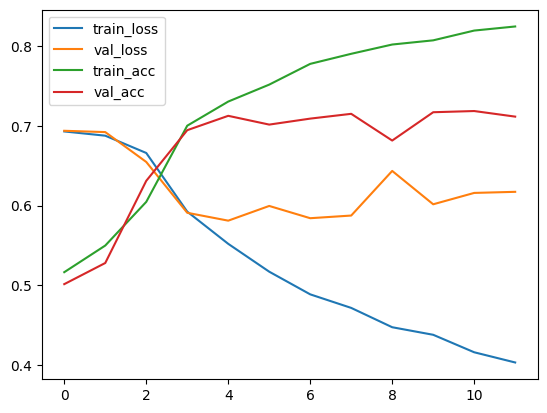

In [12]:
train_func(train_seq.to(torch.long), train_target, ebd_lstm_model)

In [13]:
test_dataset = TensorDataset(test_seq.to(torch.long), test_target)
test_loader = DataLoader(test_dataset, batch_size=65)

criterion = nn.BCELoss()

loss, accuracy = evaluate_model(ebd_lstm_model, test_loader, criterion)
loss, accuracy

(0.6296375974432215, 0.7094)

##### Stacked LSTM (Embedding + LSTM + LSTM)

In [ ]:
class StackedSentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(StackedSentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.lstm1 = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        _, (hidden, _) = self.lstm2(x)
        out = self.fc(hidden)
        return self.sigmoid(out)

In [15]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1
EMBEDDING_DIM = 50

stacked_lstm_model = StackedSentimentLSTM(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM
)

print(stacked_lstm_model)

StackedSentimentLSTM(
  (embedding): Embedding(300, 50)
  (lstm1): LSTM(50, 8, batch_first=True)
  (lstm2): LSTM(8, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoch 1/100 | Train Loss: 0.6937, Train Acc: 0.5041, Val Loss: 0.6930, Val Acc: 0.5070
Epoch 2/100 | Train Loss: 0.6895, Train Acc: 0.5391, Val Loss: 0.6862, Val Acc: 0.5430
Epoch 3/100 | Train Loss: 0.6688, Train Acc: 0.5972, Val Loss: 0.6685, Val Acc: 0.6155
Epoch 4/100 | Train Loss: 0.6449, Train Acc: 0.6379, Val Loss: 0.6849, Val Acc: 0.6020
Epoch 5/100 | Train Loss: 0.6300, Train Acc: 0.6541, Val Loss: 0.6713, Val Acc: 0.6115
Epoch 6/100 | Train Loss: 0.6021, Train Acc: 0.6881, Val Loss: 0.6541, Val Acc: 0.6485
Epoch 7/100 | Train Loss: 0.6091, Train Acc: 0.6819, Val Loss: 0.6727, Val Acc: 0.6245
Epoch 8/100 | Train Loss: 0.5859, Train Acc: 0.7045, Val Loss: 0.6663, Val Acc: 0.6295
Epoch 9/100 | Train Loss: 0.5916, Train Acc: 0.6915, Val Loss: 0.6437, Val Acc: 0.6575
Epoch 10/100 | Train Loss: 0.5749, Train Acc: 0.7044, Val Loss: 0.6445, Val Acc: 0.6600
Epoch 11/100 | Train Loss: 0.5648, Train Acc: 0.7066, Val Loss: 0.6545, Val Acc: 0.6170
Epoch 12/100 | Train Loss: 0.5451, Train 

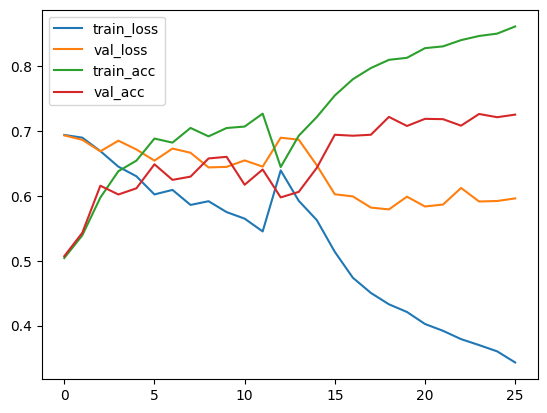

In [16]:
train_func(train_seq.to(torch.long), train_target, stacked_lstm_model)

In [17]:
test_dataset = TensorDataset(test_seq.to(torch.long), test_target)
test_loader = DataLoader(test_dataset, batch_size=65)

criterion = nn.BCELoss()

loss, accuracy = evaluate_model(stacked_lstm_model, test_loader, criterion)
loss, accuracy

(0.6288579830101558, 0.7212)

##### Stacked LSTM (Embedding + LSTM + LSTM + Dropout)

In [ ]:
class StackedDOSentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout_rate):
        super(StackedDOSentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.lstm1 = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.lstm2 = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        _, (hidden, _) = self.lstm2(x)
        x = self.dropout2(hidden)
        out = self.fc(x)
        return self.sigmoid(out)

In [19]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1
EMBEDDING_DIM = 50
DROPOUT_RATE = 0.3

stacked_do_lstm_model = StackedDOSentimentLSTM(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    dropout_rate=DROPOUT_RATE
)

print(stacked_do_lstm_model)

StackedDOSentimentLSTM(
  (embedding): Embedding(300, 50)
  (lstm1): LSTM(50, 8, batch_first=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (lstm2): LSTM(8, 8, batch_first=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoch 1/100 | Train Loss: 0.6934, Train Acc: 0.5011, Val Loss: 0.6927, Val Acc: 0.5050
Epoch 2/100 | Train Loss: 0.6929, Train Acc: 0.5225, Val Loss: 0.6929, Val Acc: 0.5170
Epoch 3/100 | Train Loss: 0.6867, Train Acc: 0.5347, Val Loss: 0.6844, Val Acc: 0.5605
Epoch 4/100 | Train Loss: 0.6773, Train Acc: 0.5686, Val Loss: 0.6839, Val Acc: 0.5605
Epoch 5/100 | Train Loss: 0.6560, Train Acc: 0.6079, Val Loss: 0.6581, Val Acc: 0.6195
Epoch 6/100 | Train Loss: 0.6445, Train Acc: 0.6438, Val Loss: 0.6553, Val Acc: 0.6290
Epoch 7/100 | Train Loss: 0.6317, Train Acc: 0.6584, Val Loss: 0.6706, Val Acc: 0.6105
Epoch 8/100 | Train Loss: 0.6393, Train Acc: 0.6464, Val Loss: 0.6688, Val Acc: 0.5935
Epoch 9/100 | Train Loss: 0.6353, Train Acc: 0.6522, Val Loss: 0.6629, Val Acc: 0.6130
Epoch 10/100 | Train Loss: 0.6199, Train Acc: 0.6687, Val Loss: 0.6530, Val Acc: 0.6355
Epoch 11/100 | Train Loss: 0.6022, Train Acc: 0.6940, Val Loss: 0.6414, Val Acc: 0.6495
Epoch 12/100 | Train Loss: 0.5807, Train 

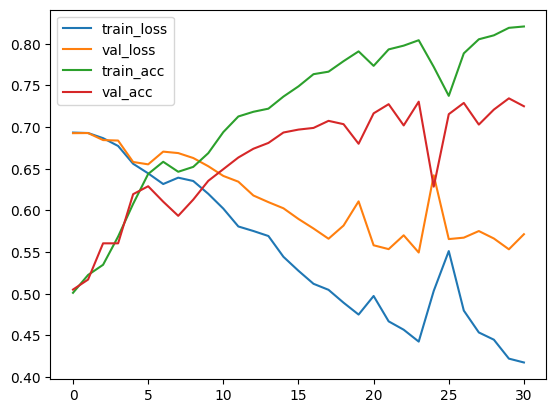

In [20]:
train_func(train_seq.to(torch.long), train_target, stacked_do_lstm_model)

In [21]:
test_dataset = TensorDataset(test_seq.to(torch.long), test_target)
test_loader = DataLoader(test_dataset, batch_size=65)

criterion = nn.BCELoss()

loss, accuracy = evaluate_model(stacked_do_lstm_model, test_loader, criterion)
loss, accuracy

(0.5799941192199658, 0.7136)

##### [참고] Bidirectional LSTM

In [22]:
from tensorflow.keras import models, layers
import numpy as np

B = 2    # batch_size
T = 5    # timestep (= sequence_len)
D = 10   # embedding_dim
U = 3    # unit(뉴런수)

x = np.random.randn(B, T, D)

def bi_lstm(x, return_sequences=False, return_state=False):
  input = layers.Input(shape=(T, D))
  lstm = layers.LSTM(U, return_sequences=return_sequences, return_state=return_state)
  output = layers.Bidirectional(lstm)(input)
  model = models.Model(inputs=input, outputs=output)
  model.summary()
  return model.predict(x)

output1 = bi_lstm(x)
print(output1.shape)

output2 = bi_lstm(x, return_sequences=True)
print(output2.shape)

output3, for_h_stt, for_c_stt, back_h_stt, back_c_stt = bi_lstm(x, return_state=True)
print(output3.shape, for_h_stt.shape, for_c_stt.shape, back_h_stt.shape, back_c_stt.shape)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 6)              │           336 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 336 (1.31 KB)

 Trainable params: 336 (1.31 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
(2, 6)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 5, 6)           │           336 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 336 (1.31 KB)

 Trainable params: 336 (1.31 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
(2, 5, 6)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ [(None, 6), (None, 3), │           336 │
│                                 │ (None, 3), (None, 3),  │               │
│                                 │ (None, 3)]             │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 336 (1.31 KB)

 Trainable params: 336 (1.31 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
(2, 6) (2, 3) (2, 3) (2, 3) (2, 3)
